# Trackless Jets

Ok, so this really is just a sub-study, but in the course of working through the `IP3D-Gains` notebook, it seemed like the values in the Ntuple for ip3d rnnip were getting basically -99 default values, whereas I've been using whatever the rnn set the default value to for evaluating the jets, but I'm not sure if this is right.

I'm trying to answer the questions
1. Should I be setting trackless jets to default values, or eliminating them?
2. Should I train w/o these trackless jets?
3. Does it matter?

I don't think it should matter, and maybe I should throw out jets w/o any ip3d tracks, but I guess we'll see by working through this exercise! 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import h5py

import sys
sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


For these comparison studies, I'm going to use the model trained with all of the hits variables (even though I probably won't need many of them).

Initialize method from myModel()
Loading previously trained LSTM
LSTM_50units_10dense_3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm_noEmbed


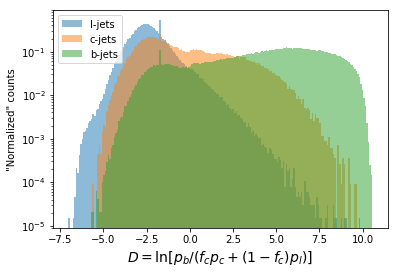

In [2]:
leffs = []
ceffs = []
beffs = []

labels = ['eval on trackless jets',
          'eval with $D_b$(nTrks=0)=-10',
          'eval w/o trackless jets']

dataTag = "3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm"
f = h5py.File("../data/mc16d/data_{}.hdf5".format(dataTag),"r")

X  = f['X_test'][:]
y  = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

nJets, nTrks, nFeatures = X.shape

# Open the model
m = myLSTM(doEmbedding=False, timeSteps=nTrks, loadModel=True, 
           modelDir="../models/mc16d/", nFeatures=nFeatures, 
           dataTag=dataTag+"_noEmbed")

print(m.modelName)

# Get the efficiencies
(l_eff, c_eff, b_eff), disc = sigBkgEff(m, X, y, ix, returnDisc=True)
 
leffs.append(l_eff)
ceffs.append(c_eff)
beffs.append(b_eff)

Next: Evaluate with the discriminant for these trackless jets set to a default value, like -99.

In [3]:
filepath = "../data/mc16d"
data_tag = "3m_15trks_sd0_rev"

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(filepath,data_tag), key='jet_df')
#trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(filepath,data_tag))

In [4]:
trackless_mask = (jet_df.loc[ix,'ip3d_ntrk'] == 0)

In [5]:
# Modify the discriminant
disc[trackless_mask] = -10

In [6]:
def effFromDisc(disc,y,tag):
    '''
    This is a section of the code from sigBkgEff for when I just 
    want to modify the discriminant and look at the resulting plot.
    
    Inputs:
    - disc
    - y
    -tag
    '''

    discMax = np.max(disc)
    discMin = np.min(disc)

    myRange=(discMin,discMax)

    effs = []
    for output, flavor in zip([0,1,2], ['l','c','b']):

        indices = (y == output)

        # Plot the discriminant output
        nEntries, edges ,_ = plt.hist(disc[indices],alpha=0.5,label='{}-jets'.format(flavor),
                                      bins=200, range=myRange, density=True, log=True)

        # Calculate the baseline signal and bkg efficiencies
        eff = calculateEff(nEntries)
        effs.append(eff)

        
    plt.legend()
    plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)
    plt.ylabel('"Normalized" counts')
    if len(tag) > 0:
        plt.savefig('../figures/mc16d/disc_{}_{}.pdf'.format(m.modelName, tag))

    return effs

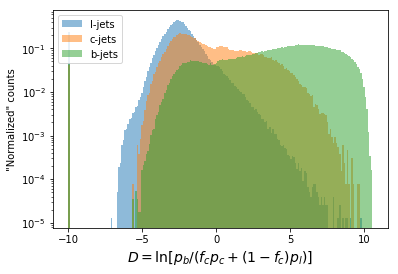

In [7]:
l_eff, c_eff, b_eff = effFromDisc(disc,y,tag='tracklessJets-10')
 
leffs.append(l_eff)
ceffs.append(c_eff)
beffs.append(b_eff)

../plottingFcts.py:212: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


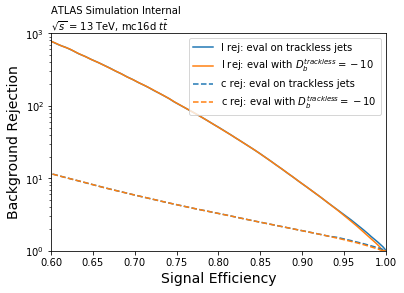

In [8]:
labels = ['eval on trackless jets',
          'eval with $D_b^{trackless}=-10$',
          'eval w/o trackless jets']
myLabels = ['{} rej: {}'.format(pdg,l) for pdg in ['l','c'] for l in labels[:2]]

plotROC(beffs[:2]*2, leffs[:2]+ceffs[:2], labels=myLabels,
        colors=['C0','C1']*2, styles=['-','-','--','--'],
        tag='spike-10')

Next: Remove these trackless jets all together.

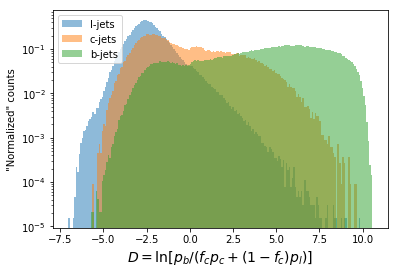

In [9]:
l_eff, c_eff, b_eff = effFromDisc(disc[disc!=-10],y[disc!=-10],'noTracklessJets')
 
leffs.append(l_eff)
ceffs.append(c_eff)
beffs.append(b_eff)

Ok, so by removing the trackless jets, we got rid of the spike in the discriminant distribution (as desired).

../plottingFcts.py:212: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


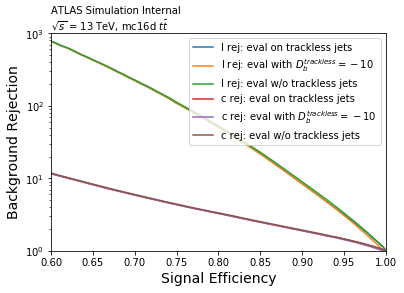

In [10]:
myLabels = ['{} rej: {}'.format(pdg,l) for pdg in ['l','c'] for l in labels]

plotROC(beffs*2,leffs+ceffs,labels=myLabels)

Maybe I should try just comparing the blue and green lines...

../plottingFcts.py:212: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


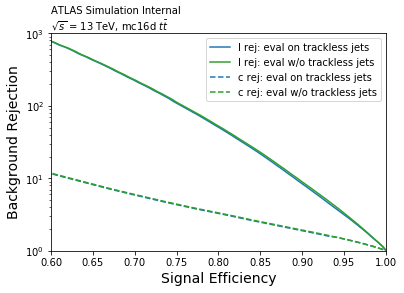

In [11]:
myLabels = ['{} rej: {}'.format(pdg,l) for pdg in ['l','c'] for l in [labels[0],labels[2]]]

plotROC([beffs[0],beffs[2]]*2,
        [leffs[0],leffs[2],ceffs[0],ceffs[2]],
        labels=myLabels,colors=['C0','C2']*2, styles=['-','-','--','--'],
        tag='evalNoTrackless')

Ok, so the last step is to c.f. the net that was trained without the trackless jets.

I'm not sure if I want to add this functionality to my repo yet, so I'm going to go ahead and save the trackless jets files here, and I should be able to train the model by appending `noTrackless` to the `sort_flag`.

**Plan:**
- Open the old dataset
- Create a file to save the new datasets
- First acccess the trackless mask for the train and then the test set
- Iterate through the rest of the variables to append the jets w/ tracks
- Close the files

In [12]:
dataTag = "3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm"
f_old = h5py.File("../data/mc16d/data_{}.hdf5".format(dataTag),"r")

f_new = h5py.File("../data/mc16d/data_{}.hdf5".format(dataTag+"_noTrackless"),"w")

for mode in ['train','test']:
    
    ixi = f_old['ix_{}'.format(mode)][:]
    trkMask = (jet_df.loc[ixi,'ip3d_ntrk'] != 0)
    
    for var in ['X','y','ix','weights']:
        
        key = '{}_{}'.format(var,mode)
        myVar = f_old[key][:]
        f_new.create_dataset(key,data=myVar[trkMask])

f_old.close()
#f_new.close()

Ok, so I think the job is *done* training right now... so I can look + compare!!

Initialize method from myModel()
Loading previously trained LSTM
Loss / acc for LSTM_50units_10dense_3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm_noTrackless


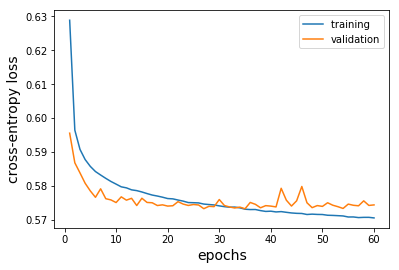

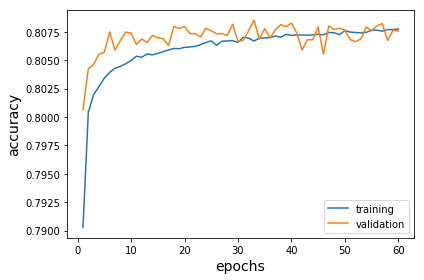

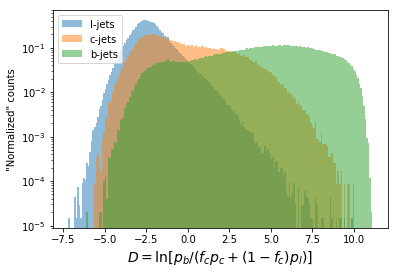

In [13]:
X = np.copy(f_new['X_test'])
y = np.copy(f_new['y_test'])
ix = np.copy(f_new['ix_test'])

m = myLSTM(doEmbedding=False, timeSteps=nTrks, loadModel=True, 
           modelDir="../models/mc16d/", nFeatures=nFeatures, 
           dataTag=dataTag+"_noTrackless")

# Plot the training curves
print("Loss / acc for {}".format(m.modelName))
trainingMetrics(m.modelName,modelDir="../models/mc16d/")

# Get the efficiencies
(l_eff, c_eff, b_eff), disc = sigBkgEff(m, X, y, ix, returnDisc=True)
 
leffs.append(l_eff)
ceffs.append(c_eff)
beffs.append(b_eff)

labels.append('train w/o trackless jets')

../plottingFcts.py:212: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


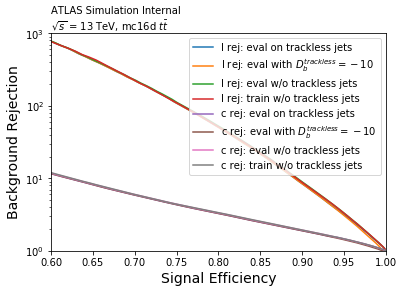

In [14]:
myLabels = ['{} rej: {}'.format(pdg,l) for pdg in ['l','c'] for l in labels]
plotROC(beffs*2,leffs+ceffs,labels=myLabels)

**Conclusion:**

It really doesn't make a difference, but to show this explicitly, I think I'm going to break these curves out individually!

../plottingFcts.py:212: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


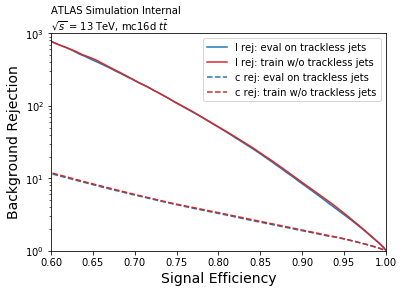

In [15]:
myLabels = ['{} rej: {}'.format(pdg,l) for pdg in ['l','c'] for l in [labels[0],labels[-1]]]

plotROC([beffs[0],beffs[-1]]*2,
        [leffs[0],leffs[-1],ceffs[0],ceffs[-1]],
        labels=myLabels,colors=['C0','C3']*2, styles=['-','-','--','--'],
        tag='trainNoTrackless')

../plottingFcts.py:212: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


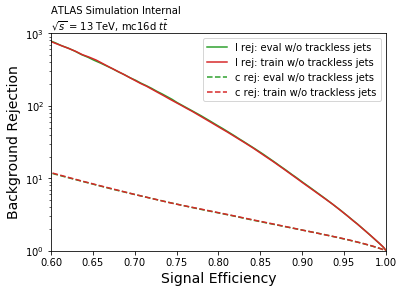

In [16]:
myLabels = ['{} rej: {}'.format(pdg,l) for pdg in ['l','c'] for l in [labels[-2],labels[-1]]]

plotROC([beffs[-2],beffs[-1]]*2,
        [leffs[-2],leffs[-1],ceffs[-2],ceffs[-1]],
        labels=myLabels,colors=['C2','C3']*2, styles=['-','-','--','--'],
        tag='evalVsTrainNoTrackless')